# Variational optimization of Rabi

In [1]:
# front matter
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.special import hermite
from math import factorial
from scipy.optimize import minimize
import scipy.linalg as la
import pickle

# If your screen has retina display this will increase resolution of plots
%config InlineBackend.figure_format = 'retina' 

with open("psi.pickle", "rb") as f0:
    psi = pickle.load(f0)
with open("E.pickle", "rb") as f1:
    E = pickle.load(f1)

In [2]:
# Basic constants
# grids
N=2000 

# spatial grid
XMin=-50
XMax=50
X=np.linspace(XMin, XMax, N)

# momentum grid
P=(2*np.pi/(XMax-XMin))*np.concatenate((np.arange(N//2), np.arange(-N//2,0))) 

w1=1 
w0=0.35

#define pauli matrixes
S0 = np.array([[1, 0], [0, 1]])
S1 = np.array([[0, 1], [1, 0]])
S3 = np.array([[1, 0], [0, -1]])

dt=0.25

## Function Defination

In [3]:
# Partition function
def Z(w,a,b,n,beta):
    Z_0=0
    for v in range(n):
        energy = E[w, a, b][v]
        Z_0 += np.exp(-beta * energy)  
    return Z_0

# Helmholtz free energy difference
def delta_F(a,b,n,beta):
    delta_F_0=1/beta*math.log(Z(0,a,b,n,beta)/Z(1,a,b,n,beta))
    return delta_F_0

In [4]:
def simulation(a,b,v,tau,wp):
    M = int(tau/dt)
    psi_0 = psi[0,a,b][v]
    psi_1 = np.zeros(2*N, dtype=np.complex128)
    psi_2 = np.zeros(2*N, dtype=np.complex128)
    psi_3 = np.zeros(2*N, dtype=np.complex128)

    UT = np.exp(-1j*(P**2/2)*dt/2)

    for m in range(M):
        # momentum 1/2 update
        # saperate spin up and down
        psi_0_up = psi_0[::2]    
        phi_0_up = np.fft.fft(psi_0_up) 
        phi_1_up = UT*phi_0_up
        psi_1_up = np.fft.ifft(phi_1_up)

        psi_0_down=psi_0[1::2]
        phi_0_down = np.fft.fft(psi_0_down)
        phi_1_down= UT*phi_0_down
        psi_1_down=np.fft.ifft(phi_1_down)

        psi_1[::2] = psi_1_up
        psi_1[1::2] = psi_1_down

        Vcase = np.einsum('i,jk->ijk', (wp[m]*X)**2/2, S0) + np.einsum('i,jk->ijk', a*X, S1) + b*S3
        UV = la.expm(-1j*Vcase*0.25)
        psi_2 = np.einsum('ijk,ik->ij', UV, psi_1.reshape(-1, 2))
        psi_2 = psi_2.reshape(-1)
        
        # momentum 1/2 update
        # saperate spin up and down
        psi_2_up = psi_2[::2]    
        phi_2_up = np.fft.fft(psi_2_up) 
        phi_3_up = UT*phi_2_up
        psi_3_up = np.fft.ifft(phi_3_up)

        psi_2_down=psi_2[1::2]
        phi_2_down = np.fft.fft(psi_2_down)
        phi_3_down= UT*phi_2_down
        psi_3_down=np.fft.ifft(phi_3_down)

        # combine up and down
        psi_3[::2] = psi_3_up
        psi_3[1::2] = psi_3_down

        psi_0 = psi_3
    return psi_0

In [5]:
def var(a,b,n,tau,beta,wp):
    Fm=0.0
    Sm=0.0
    Z0= Z(0,a,b,n,beta)
    DF= delta_F(a,b,n,beta)
    for i in range(n):
        for j in range(n):
            psi_t=simulation(a,b,i,tau,wp)
            psi1=psi[1,a,b][j]
            abs_dot=np.abs(np.dot(psi1,psi_t))**2
            Fm+=np.exp(-beta*E[1,a,b][j])*abs_dot/Z0
            Sm+=np.exp(-beta*(2*E[1,a,b][j]-E[0,a,b][i]))*abs_dot/Z0
    Var=Sm-Fm**2
    Var_dis=Var/np.exp(-2*beta*DF)
    return Var_dis

## N-dimensional polynomial work protocal
$\omega(t) = \omega_0 + a_1 t + a_2 t^2 + \cdots + a_{k-1} t^{k-1} + a_k t^k$

In [6]:
# N-dimensional polynomial work protocal
# power_t vector (t_j^0, t_j^1, ..., t_j^(n-1))
def power_vector(k,tau):
    M=int(tau/dt)
    t_list = np.linspace(0, tau, M)
    return np.array([[t_list[j]**i for i in range(k)] for j in range(M)])

# work protocal
def wp_poly(a_list,tau):
    M=int(tau/dt)
    n = len(a_list)+2
    q=np.sum(power_vector(n-2,tau)[M-1]*a_list)
    a1=(w1-w0)/tau-q*tau
    a_list = np.append([w0, a1],a_list)
    p = [round(np.sum(power_vector(n,tau)[i]*a_list), 8) for i in range(M)]
    return p

### Constrained optimization

In [7]:
a=5
b=5
n=150
tau=10

beta=4
# Define target function
def poly_target_function(a_list):
    return var(a,b,n,tau,beta,wp_poly(a_list,tau))

# Constraint function
def constraint_func(a_list):
    return wp_poly(a_list,tau)

# Initial parameter value
poly_initial_list = np.array(np.random.rand(5))

# Minimize the target function with the constraint
poly_optimization = minimize(poly_target_function, poly_initial_list, method='COBYLA', constraints={'type': 'ineq', 'fun': constraint_func})

# Output the optimized parameter and the m
# inimum value
poly_optimized_list = poly_optimization.x
poly_min_value = poly_optimization.fun

print("Converge :", poly_optimization.success)

Converge : True


In [8]:
print("Initial parameter list:", poly_initial_list)
print("Optimized parameter list:", poly_optimized_list)
print(wp_poly(poly_optimization.x,tau))
print("Minimized Variance:", poly_min_value)

Initial parameter list: [0.62922078 0.50579699 0.43960405 0.37604537 0.9222199 ]
Optimized parameter list: [ 1.46884781  0.49483344  1.46634709  0.24227432 -0.04086696]
[0.35, 34.69208099, 69.3734288, 104.70628369, 141.20133506, 179.57903906, 220.77257413, 265.9224343, 316.36266046, 373.59870945, 439.27696097, 515.14586244, 603.00871166, 704.66807736, 821.86185759, 956.19097604, 1109.03871612, 1281.48169298, 1474.1924634, 1687.33377347, 1920.44444422, 2172.31689508, 2440.86630514, 2722.99141243, 3014.42695087, 3309.58772525, 3601.40432398, 3881.15046971, 4138.26200789, 4360.14753308, 4531.99065319, 4636.54389163, 4653.91422718, 4561.34027189, 4332.96108674, 3939.57663517, 3348.39987454, 2522.80048535, 1422.04023845, 1.0]
Minimized Variance: 3.069335607022324e+57


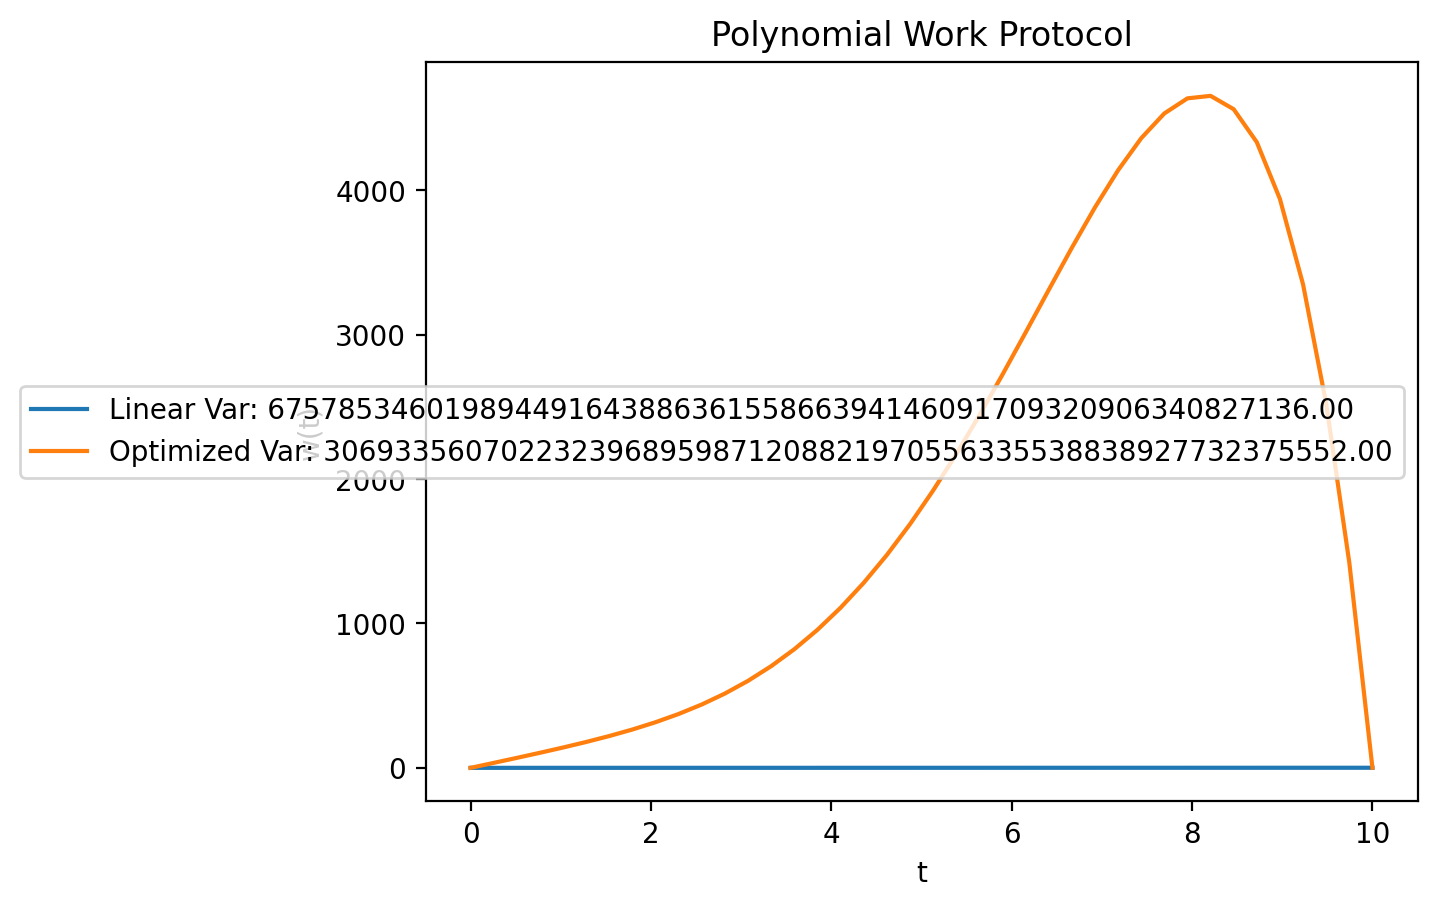

In [9]:
M=int(tau/dt)
t_list = np.linspace(0, tau, M)


# Visualization
# x-axis
Poly_x_Var = t_list[M//2]

# initial work protocol guess
# plt.plot(t_list, wp_poly(poly_initial_list), label=f'Initial guessed Var: {var(wp_poly(poly_initial_list)):.2f}')
# poly_y_Var_initial = wp_poly(poly_initial_list)[M//2]

linear_list=np.array(np.zeros(20))
plt.plot(t_list, wp_poly(linear_list,tau), label=f'Linear Var: {var(a,b,n,tau,beta,wp_poly(linear_list,tau)):.2f}')
poly_y_Var_initial = wp_poly(linear_list,tau)[M//2]


# optimized work protocol
plt.plot(t_list, wp_poly(poly_optimization.x,tau),label=f'Optimized Var: {var(a,b,n,tau,beta,wp_poly(poly_optimization.x,tau)):.2f}')
poly_y_Var_optimized = wp_poly(poly_optimization.x,tau)[M//2]

plt.xlabel("t")
plt.ylabel("w(t)")
plt.title("Polynomial Work Protocol")
plt.legend()
plt.show()
